In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [2]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None


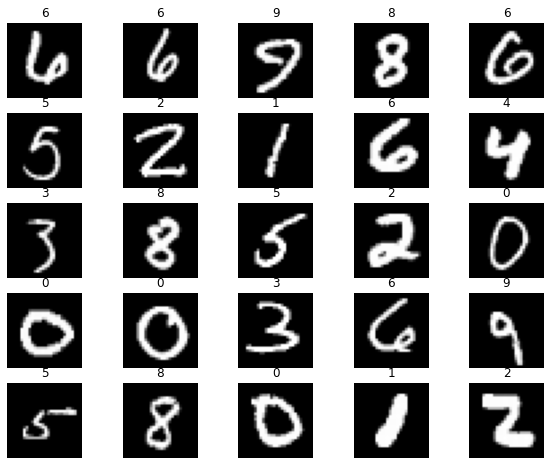

In [3]:
import matplotlib.pyplot as plt 

figure = plt.figure(figsize=(10,8))
cols , rows = 5,5
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(train_data), size= (1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap= 'gray')
    plt.title(label)
    plt.axis("off")

plt.show()

In [4]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1539e6fa0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1539f6df0>}

In [30]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=5,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(5, 5, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # Output height = (Input height 
        # + padding height top + padding height bottom - kernel height)
        #  / (stride height) + 1.
        # for maxpool of 2, the output lenght become half => 7
        self.out = nn.Linear(5*7*7,10)
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        x = F.softmax(x, dim=1)

        return output, x



cnn = CNN()
cnn


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=245, out_features=10, bias=True)
)

In [31]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [32]:
optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [33]:

num_epochs= 10

def train(num_epochs, cnn, loaders):
    cnn.train()
    total_step = len(loaders['train'])
    for epoch in range(num_epochs):
        for i, (image, label) in enumerate(loaders['train']):
            output, img = cnn(image)
            loss = loss_func(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1)%100==0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                       


In [34]:
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.2290
Epoch [1/10], Step [200/600], Loss: 0.0658
Epoch [1/10], Step [300/600], Loss: 0.0404
Epoch [1/10], Step [400/600], Loss: 0.1881
Epoch [1/10], Step [500/600], Loss: 0.0402
Epoch [1/10], Step [600/600], Loss: 0.0548
Epoch [2/10], Step [100/600], Loss: 0.0886
Epoch [2/10], Step [200/600], Loss: 0.0535
Epoch [2/10], Step [300/600], Loss: 0.0694
Epoch [2/10], Step [400/600], Loss: 0.0827
Epoch [2/10], Step [500/600], Loss: 0.1672
Epoch [2/10], Step [600/600], Loss: 0.1452
Epoch [3/10], Step [100/600], Loss: 0.0916
Epoch [3/10], Step [200/600], Loss: 0.0413
Epoch [3/10], Step [300/600], Loss: 0.0991
Epoch [3/10], Step [400/600], Loss: 0.0422
Epoch [3/10], Step [500/600], Loss: 0.0132
Epoch [3/10], Step [600/600], Loss: 0.0500
Epoch [4/10], Step [100/600], Loss: 0.0417
Epoch [4/10], Step [200/600], Loss: 0.1148
Epoch [4/10], Step [300/600], Loss: 0.0431
Epoch [4/10], Step [400/600], Loss: 0.0772
Epoch [4/10], Step [500/600], Loss: 0.0452
Epoch [4/10

In [35]:
def test():
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output,1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)



In [36]:
test()

Test Accuracy of the model on the 10000 test images: 0.98


In [37]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [38]:
actual_number = lbls[:10].numpy()
actual_number

array([3, 2, 1, 4, 9, 5, 4, 3, 0, 1])

In [39]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [3 2 1 4 9 5 4 3 0 1]
Actual number: [3 2 1 4 9 5 4 3 0 1]


In [41]:
test_output

tensor([[-17.4273, -14.7196,  -5.2238,  15.8442, -19.5190,  -1.8639, -13.5651,
          -3.1432,   0.9250,  -7.3770],
        [-11.4906,  -9.3679,  12.4987,  -5.3418,  -5.5706, -13.1705, -14.7806,
         -13.1186,   5.7418, -10.8851],
        [-16.2441,  14.9619,  -3.0205, -12.9501,   2.8719,  -6.5749,  -2.6021,
           1.4911,  -4.3747,  -6.8983],
        [ -5.6060,  -9.6544,  -1.3926,  -9.3475,  11.1471,  -8.6149, -12.8252,
          -7.1167,  -2.3259,  -8.9031],
        [ -7.6247,  -1.7863,  -7.2182,  -7.3606,   3.7709,  -9.0029, -15.7644,
          -2.5592,  -0.0836,   4.1512],
        [ -7.3002,  -1.0712, -18.3171,  -6.3492, -12.1029,   9.4007,  -0.4069,
         -12.3859,  -0.9141,  -4.4013],
        [-13.4542,  -9.8977, -12.2558, -25.6468,  18.5048,  -6.4046,  -6.0766,
          -2.2065,  -3.6395,  -7.4183],
        [ -9.9539, -15.7223,  -0.9024,  11.0979,  -7.5146,  -1.1331, -16.0447,
          -3.9534,  -1.5333,  -7.1578],
        [ 17.5196, -28.5408,  -1.2383, -11.8003,